In [3]:
%load_ext autoreload
%autoreload 2
# Imports
import pandas as pd
from scipy.sparse import csr_matrix
import pandas
import numpy as np
from matplotlib import pyplot as plt
import math
from sklearn.neighbors import NearestNeighbors
from surprise import Dataset, Reader
from surprise.dataset import DatasetAutoFolds
from surprise import KNNWithMeans
from surprise.model_selection import GridSearchCV
from tqdm import tqdm
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from surprise.prediction_algorithms.matrix_factorization import NMF
from IPython.core.display_functions import display
from surprise import SVD
from sklearn.metrics import mean_squared_error
from typing import List
from sklearn.model_selection import KFold
from surprise import Prediction
from typing import Dict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Question 1

In [4]:
# Import data
seed = 42
ratings_df = pandas.read_csv('data/ratings.csv', index_col=0,
                             dtype={'userId': int, 'movieId': int, 'rating': float, 'timestamp': int})
print('ratings')
ratings_df.head()

ratings


,userId,movieId,rating,timestamp
0,496,112852,3.0,1415520462
1,391,1947,4.0,1030945141
2,387,1562,1.5,1095041022
3,474,2716,4.5,1053020930
4,483,88125,4.5,1311337237


In [5]:
movies_df = pandas.read_csv('data/movies.csv')
print('movies')
movies_df.head()

movies


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Sparsity of the movie rating dataset


In [6]:
# Get basic measures
num_users = len(pd.unique(ratings_df['userId']))
num_rated_movies = len(pd.unique(ratings_df['movieId']))
num_total_movies = movies_df.shape[0]

# Cleanup data
ratings_df['userId_reindexed'] = ratings_df['userId'] - 1  # 0-index users
print('Remapped user ids to 0-indexing...')
movie_index_map = pd.Series(movies_df.index, index=movies_df['movieId'].values).to_dict()
ratings_df['movieId_reindexed'] = ratings_df['movieId'].map(movie_index_map)
print(f"Remapped movie ids from sparse id range "
      f"{np.min(ratings_df['movieId'])}...{np.max(ratings_df['movieId'])} "
      f"to dense id range {np.min(ratings_df['movieId_reindexed'])}...{np.max(ratings_df['movieId_reindexed'])}")

Remapped user ids to 0-indexing...
Remapped movie ids from sparse id range 1...193609 to dense id range 0...9741


In [7]:
# Construct Ratings matrix
R = csr_matrix((ratings_df['rating'], (ratings_df['userId_reindexed'], ratings_df['movieId_reindexed'])),
               shape=(num_users, num_total_movies), dtype=float)
sparsity = len(R.data) / np.prod(R.shape)

print(f'The sparsity of the ratings matrix is {sparsity:.5f}')

The sparsity of the ratings matrix is 0.01697


## Histogram showing the frequency of the rating values

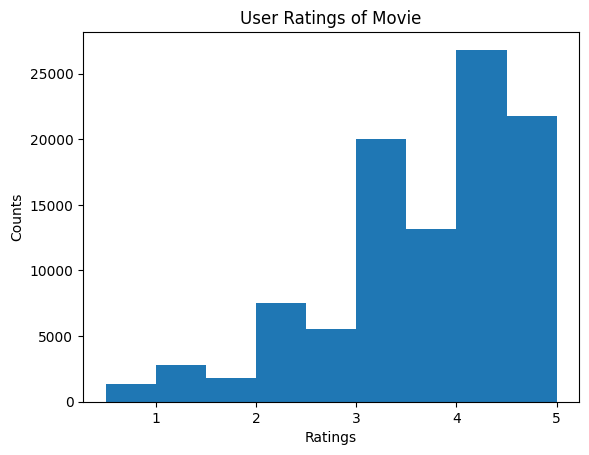

In [8]:
min_rating = np.min(ratings_df['rating'])
max_rating = np.max(ratings_df['rating'])
bin_count = (max_rating - min_rating) / 0.5 + 1
bins = np.linspace(start=min_rating, stop=max_rating, num=int(bin_count))
plt.hist(R.data, bins=bins)
plt.title('User Ratings of Movie')
plt.ylabel('Counts')
plt.xlabel('Ratings')
plt.show()

We can  observe that most users give fairly high ratings, with the majority falling into the 3-5 point range.

## Distribution of the number of ratings received among movies

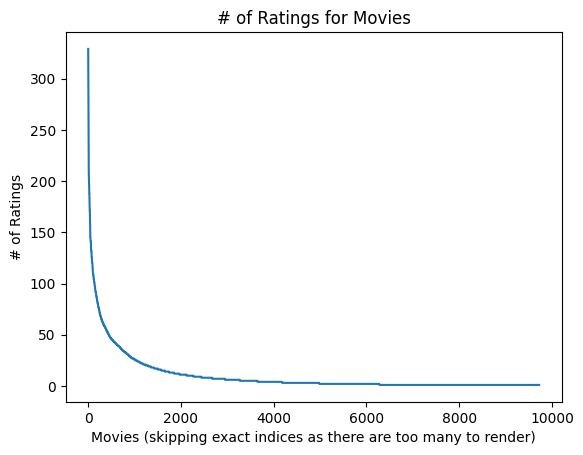

In [9]:
ratings_per_movie = ratings_df['movieId_reindexed'].value_counts()
ratings_counts = ratings_per_movie.tolist()
plt.plot(ratings_counts)
plt.title('# of Ratings for Movies')
plt.ylabel('# of Ratings')
plt.xlabel('Movies (skipping exact indices as there are too many to render)')
plt.show()

## Distribution of ratings among users

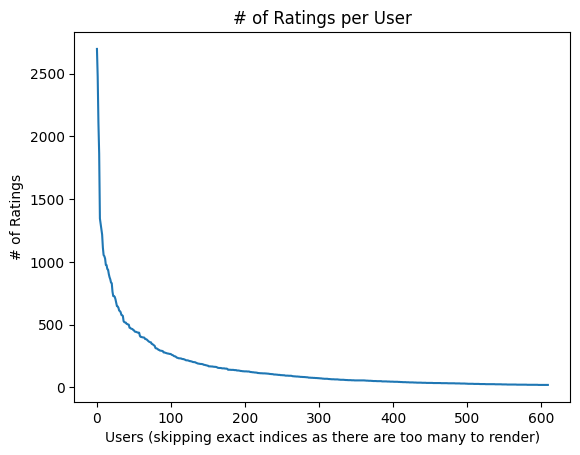

In [10]:
ratings_per_user = ratings_df['userId_reindexed'].value_counts()
ratings_counts = ratings_per_user.tolist()
plt.plot(ratings_counts)
plt.title('# of Ratings per User')
plt.ylabel('# of Ratings')
plt.xlabel('Users (skipping exact indices as there are too many to render)')
plt.show()

## Discuss the salient features of the distributions
We can observe for both movie rating counts and user rating counts, that they are not uniformly distributed. Most reviews are concentrated on ~2000 movies and submitted by only 100 users. This means that recommendation algorithms will be inclined to overfit towards those movies and users, which will negatively impact the generalisation of the recommender.

## Variance of the rating values received by each movie

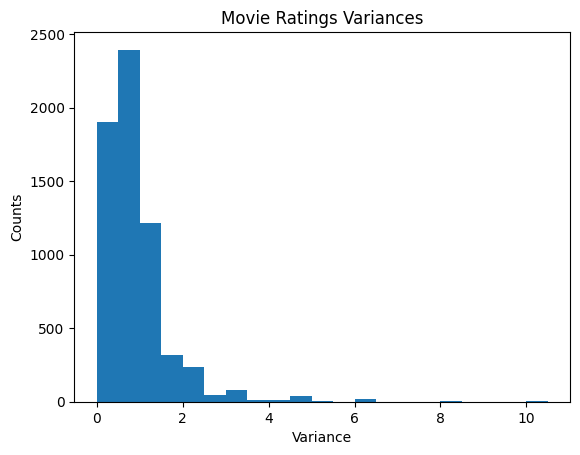

In [11]:
movie_variances = ratings_df.groupby('movieId_reindexed')['rating'].var()
min_var = np.min(movie_variances)
max_var = math.ceil(np.max(movie_variances) * 2) / 2  # Need to make sure the max val falls on .5 or .0
bin_count = (max_var - min_var) / 0.5 + 1
bins = np.linspace(start=min_var, stop=max_var, num=int(bin_count))
plt.hist(movie_variances, bins=bins)
plt.title('Movie Ratings Variances')
plt.ylabel('Counts')
plt.xlabel('Variance')
plt.show()

We can see that the variance of most movie ratings is in the 0-2 range, which suggests that most users have similar opinions (i.e ratings) on how good a movie is. There are only a few more divisive outliers with high variance.

# Question 2

## The formula for $\mu_u$
We can calculate the sample mean of user $u$ to be:

$$
\mu_u = \frac{1}{\vert I_u \vert} \sum_{k\in I_u} r_{uk}
$$

## The meaning of $I_u \cap I_v$
This set interesection represents the set of movies that both user $u$ and $v$ have rated. If $I_u \cap I_v = \emptyset$, then this means they have no movie ratings in common. Given the sparsity of $R$, we can expect that many such pairs of $u,v$ exist.

# Question 3

## Understanding the Prediction function
The reason why we prefer to center the rating $r_{vj}$ of some movie $j$ by a user $v$'s mean $\mu_v$ is that ratings are not perceived or utilised the same way by users. For example, if two users $a$ and $b$ view a movie and both dislike it, $a$ may give it a rating of $3.5/5$ and $b$ may give it a $2/5$. To decide whether this means that $b$ disliked the movie more than $a$, it helps to contextualise this rating with the average of all their ratings. If $\mu_a = 4.0$ and $\mu_a = 2.5$, then they actually both saw it to be $0.5$ below their respective averages.

# Question 4

In [12]:
# Prepare data
def df_to_dataset(df: pd.DataFrame) -> DatasetAutoFolds:
    reader = Reader(line_format='user item rating', sep=',', skip_lines=0, rating_scale=(min_rating, max_rating))
    return Dataset.load_from_df(df[['userId_reindexed', 'movieId_reindexed', 'rating']], reader)

In [13]:
# Search KNN space
dataset = df_to_dataset(ratings_df)
hyper_params = {
    'k': np.arange(2, 102, 2, dtype=int),
    'sim_options': {'name': ['pearson']},
    'verbose': [False]
}
search = GridSearchCV(KNNWithMeans, hyper_params, cv=10, n_jobs=8, joblib_verbose=0)
search.fit(dataset)

In [14]:
# Plot
def plot_rmse_mae(search, title: str, x_label: str, k_vals: List[int]):
    mean_rmse = search.cv_results['mean_test_rmse']
    mean_mae = search.cv_results['mean_test_mae']
    plt.plot(k_vals, mean_rmse, label='RMSE')
    plt.plot(k_vals, mean_mae, label='MAE')
    plt.title(title)
    plt.ylabel('Error')
    plt.xlabel(x_label)
    plt.legend()
    plt.show()

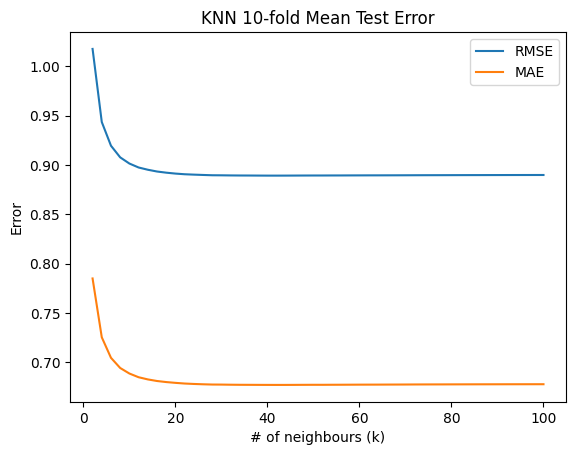

In [15]:
plot_rmse_mae(search, 'KNN 10-fold Mean Test Error', '# of neighbours (k)', search.cv_results['param_k'])

# Question 5
The minimum $k$ appears to be roughly at $k=20$, as both error functions reach a steady state then.

In [16]:
min_k = 20
mae_steady = search.cv_results['mean_test_mae'][min_k]
rmse_steady = search.cv_results['mean_test_rmse'][min_k]
print(f'Steady MAE is {mae_steady:.5f}')
print(f'Steady RMSE is {rmse_steady:.5f}')

Steady MAE is 0.67690
Steady RMSE is 0.88923


# Question 6

In [17]:
# Dataset trimmers
def trim_for_popular_movies(df: pd.DataFrame, more_ratings_than=2) -> pd.DataFrame:
    counts = df.groupby('movieId_reindexed')['movieId_reindexed'].value_counts()  # count movie ids
    movie_ids = counts[counts > more_ratings_than].index.get_level_values(0)  # filter those with too few ratings
    return df[df['movieId_reindexed'].isin(movie_ids)]  # pick relevant rows


def trim_for_unpopular_movies(df: pd.DataFrame) -> pd.DataFrame:
    counts = df.groupby('movieId_reindexed')['movieId_reindexed'].value_counts()  # count movie ids
    movie_ids = counts[counts <= 2].index.get_level_values(0)  # filter those with too few ratings
    return df[df['movieId_reindexed'].isin(movie_ids)]  # pick relevant rows


def trim_for_high_variance_movies(df: pd.DataFrame) -> pd.DataFrame:
    trimmed_df = trim_for_popular_movies(df, more_ratings_than=4)
    movie_variances = trimmed_df.groupby('movieId_reindexed')['rating'].var()
    high_enough_var_ids = movie_variances[movie_variances >= 2].index
    return df[df['movieId_reindexed'].isin(high_enough_var_ids)]


pop_trimmed_df = trim_for_popular_movies(ratings_df)
unpop_trimmed_df = trim_for_unpopular_movies(ratings_df)
high_var_trimmed_df = trim_for_high_variance_movies(ratings_df)

In [18]:
# Search on varied datasets
def search_varied_datasets(model, hyper_params: dict, main_param: str):
    k_vals = None
    mean_rmses = []
    for df in tqdm([ratings_df, pop_trimmed_df, unpop_trimmed_df, high_var_trimmed_df]):
        dataset = df_to_dataset(df)
        search = GridSearchCV(model, hyper_params, cv=10, n_jobs=8, joblib_verbose=0)
        search.fit(dataset)

        k_vals = search.cv_results[f'param_{main_param}']
        mean_rmses.append(search.cv_results['mean_test_rmse'])
    return k_vals, mean_rmses

In [19]:
hyper_params = {
    'k': np.arange(2, 102, 2, dtype=int),
    'sim_options': {'name': ['pearson']},
    'verbose': [False]
}
k_vals, mean_rmses = search_varied_datasets(KNNWithMeans, hyper_params, 'k')

100%|██████████| 4/4 [02:13<00:00, 33.29s/it]


In [20]:
# Plotting
names = ['All Movies', 'Popular Movies', 'Unpopular Movies', 'High Variance Movies']


def plot_rmses(k_vals, mean_rmses, title: str, xlabel: str):
    for rmse, name in zip(mean_rmses, names):
        plt.plot(k_vals, rmse, label=f'RMSE - {name}')

    plt.title(title)
    plt.ylabel('Error')
    plt.xlabel(xlabel)
    plt.legend()
    plt.show()

    # Reporting
    for rmse, name in zip(mean_rmses, names):
        print(f'Min Mean RMSE for {name}: {np.min(rmse):.5f}')

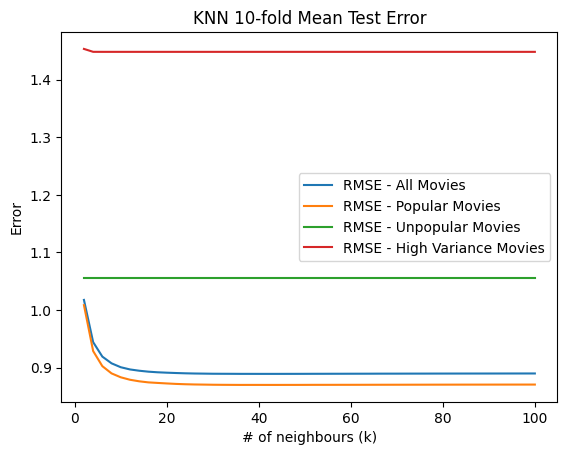

Min Mean RMSE for All Movies: 0.88926
Min Mean RMSE for Popular Movies: 0.87009
Min Mean RMSE for Unpopular Movies: 1.05604
Min Mean RMSE for High Variance Movies: 1.44811


In [21]:
plot_rmses(k_vals, mean_rmses, 'KNN 10-fold Mean Test Error', '# of neighbours (k)')

In [22]:
# Predictions for ROC Curves
true_thresholds = [2.5, 3, 3.5, 4]


def get_roc_curve_data(model, data_dfs):
    y_preds = []
    y_true_binarised = []

    for df in tqdm(data_dfs):
        dataset = df_to_dataset(df)
        train_data, validation_data = train_test_split(dataset, test_size=0.1, random_state=seed)

        model.fit(train_data)
        preds = model.test(validation_data)
        y_preds.append(preds)

        binarised_preds = []
        for t in true_thresholds:
            binarised = [0 if y.r_ui < t else 1 for y in preds]
            binarised_preds.append(binarised)
        y_true_binarised.append(binarised_preds)

    return y_preds, y_true_binarised

In [23]:
model = KNNWithMeans(k=20, sim_options={'name': 'pearson'}, verbose=False)
data_dfs = [ratings_df, pop_trimmed_df, unpop_trimmed_df, high_var_trimmed_df]
y_preds, y_true_binarised = get_roc_curve_data(model, data_dfs)

100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


In [24]:
# ROC Curves
def plot_roc_curves(y_preds, y_true_binarised):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

    for y_pred, y_true, name, ax in zip(y_preds, y_true_binarised, names, (ax1, ax2, ax3, ax4)):

        y_est = [y.est for y in y_pred]
        labels = []

        for t, y_t in zip(true_thresholds, y_true):
            fpr, tpr, _ = roc_curve(y_t, y_est)
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr)
            labels.append(f'threshold={t:.1f}, AUC={roc_auc:.3f}')
        ax.legend(labels)
        ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate', title=f'ROC for {name}')

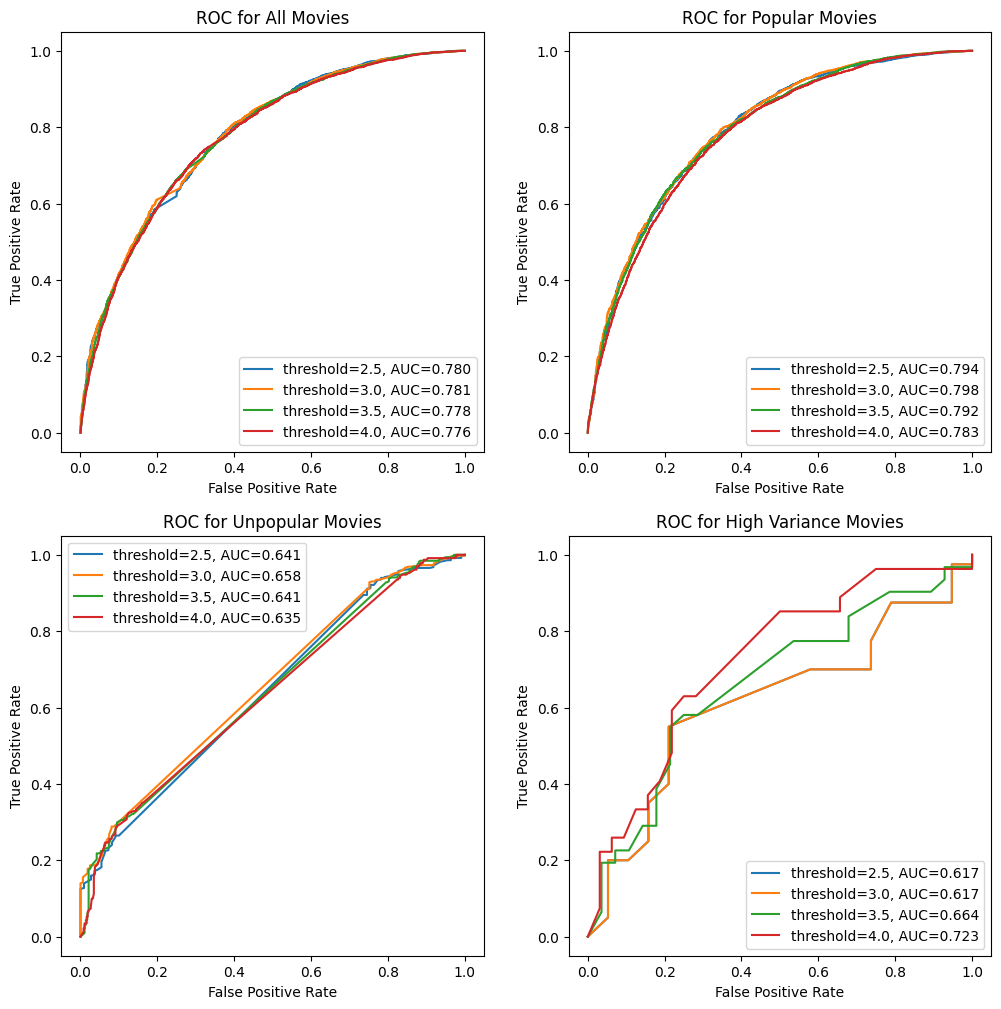

In [25]:
plot_roc_curves(y_preds, y_true_binarised)

# Question 7
No the optimisation problem is not convex, as NMF is generally non-convex unless we can show that $U$'s columns are a linear combination of $R$'s columns. We can formulate the optimisation problem in least-squares form for a fixed $U$ as follows:

$$
    \min_V \| W\odot(R - UV^T) \|_F^2 + \lambda \|V \|_F^2
$$

Where $\odot$ is the Hadamard product and it is assumed that we still want to regularise $V$.

# Question 8

## NMF-based collaborative filter on original datset

In [26]:
# Search NMF space
dataset = df_to_dataset(ratings_df)
hyper_params = {
    'n_factors': np.arange(2, 52, 2, dtype=int),
    'verbose': [False]
}
search = GridSearchCV(NMF, hyper_params, cv=10, n_jobs=8, joblib_verbose=0)
search.fit(dataset)

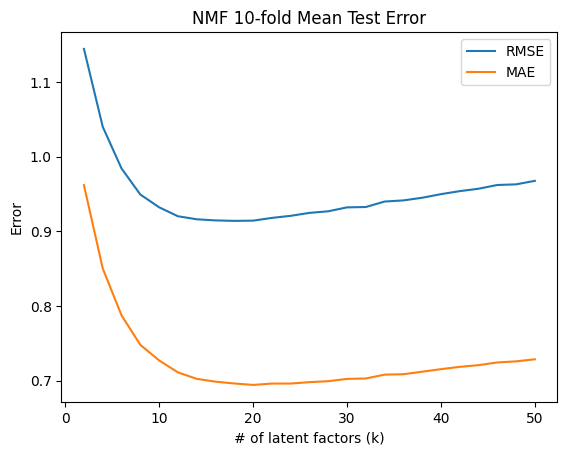

In [27]:
# Plot
plot_rmse_mae(search, 'NMF 10-fold Mean Test Error', '# of latent factors (k)', search.cv_results['param_n_factors'])

## Optimal number of latent factors

In [28]:
# Calculate # of genres
all_genres = set()


def get_genres(row):
    movie_genres = row['genres'].split('|')
    for g in movie_genres:
        all_genres.add(g)


_ = movies_df.apply(get_genres, axis=1)

all_genres.discard('(no genres listed)')

In [29]:
mean_rmse = search.cv_results['mean_test_rmse']
mean_mae = search.cv_results['mean_test_mae']
min_rmse_idx = np.argmin(mean_rmse)
min_mae_idx = np.argmin(mean_mae)

print(f'Min RMSE: {mean_rmse[min_rmse_idx]} at n_components={k_vals[min_rmse_idx]}')
print(f'Min MAE: {mean_mae[min_mae_idx]} at n_components={k_vals[min_mae_idx]}')
print(f'Number of movie genres: {len(all_genres)}')

Min RMSE: 0.914013484997924 at n_components=18
Min MAE: 0.6941448939604471 at n_components=20
Number of movie genres: 19


No the optimal number of latent factors is not the same as the number of genres, but they are close, suggesting that there may be some relationship.

## Performance on trimmed dataset subsets
Note: in this question and others we opted to also show the RMSE for all movies as it is useful to compare the reduced datasets' performance against it.

In [30]:
# Search on varied datasets
hyper_params = {
    'n_factors': np.arange(2, 52, 2, dtype=int),
    'verbose': [False]
}
k_vals, mean_rmses = search_varied_datasets(NMF, hyper_params, 'n_factors')

100%|██████████| 4/4 [02:39<00:00, 39.80s/it]


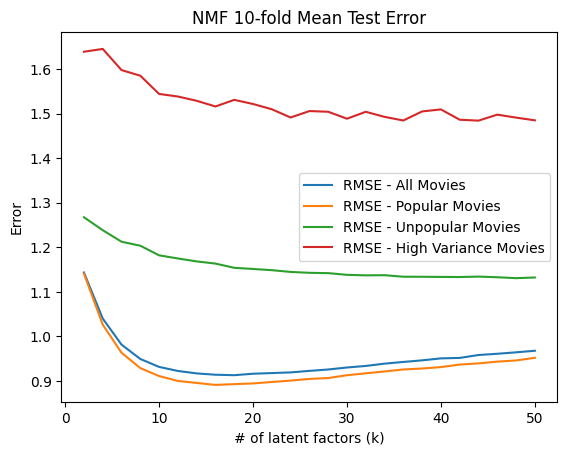

Min Mean RMSE for All Movies: 0.91272
Min Mean RMSE for Popular Movies: 0.89086
Min Mean RMSE for Unpopular Movies: 1.13068
Min Mean RMSE for High Variance Movies: 1.48450


In [31]:
# Plotting
plot_rmses(k_vals, mean_rmses, 'NMF 10-fold Mean Test Error', '# of latent factors (k)')

In [32]:
# Predictions for ROC Curves
model = NMF(n_factors=16, verbose=False)
data_dfs = [ratings_df, pop_trimmed_df, unpop_trimmed_df, high_var_trimmed_df]
y_preds, y_true_binarised = get_roc_curve_data(model, data_dfs)

100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


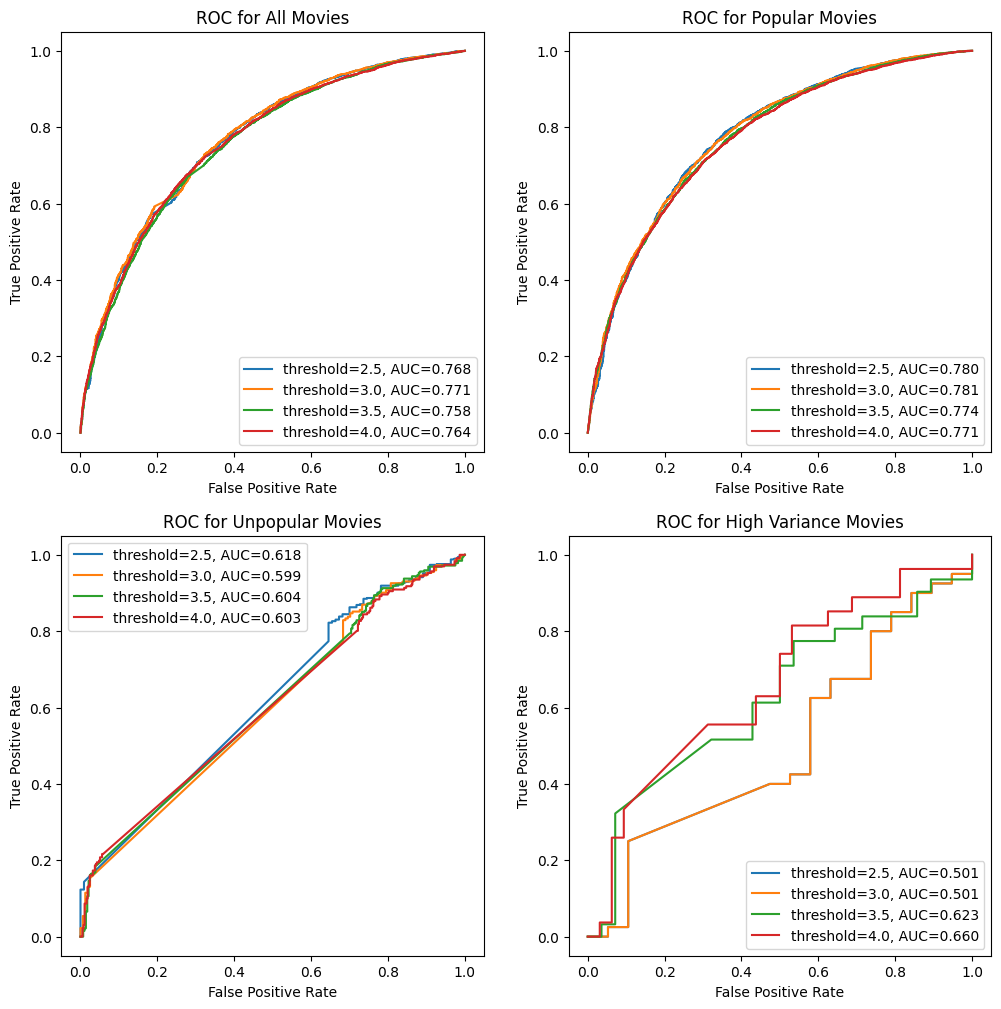

In [33]:
# ROC Curves
plot_roc_curves(y_preds, y_true_binarised)

# Question 9

In [34]:
dataset = df_to_dataset(ratings_df)
train_data = dataset.build_full_trainset()  # We're not predicting anything, so we can use the entire dataset.
nmf_model = NMF(n_factors=20, verbose=False).fit(train_data)

In [35]:
top_n = 10
top_n_movie_ids = np.argsort(nmf_model.qi, axis=0)[-top_n:, :]

picked_cols = [0, 1, 2, 5, 6, 9, 12, 15, 19]

for p in picked_cols:
    top_rows_df = movies_df.loc[top_n_movie_ids[:, p]]
    top_genres = []


    def pick_genres(row):
        for g in row['genres'].split('|'):
            top_genres.append(g)


    top_rows_df.apply(pick_genres, axis=1)
    found_genres, genre_counts = np.unique(top_genres, return_counts=True)
    top_3_genre_idx = np.argsort(genre_counts)[::-1][:3]  # reverse then pick top 3

    print(
        f'Col {p} - 3/{len(found_genres)} most common genres: {found_genres[top_3_genre_idx]}, {genre_counts[top_3_genre_idx]}')

    display(top_rows_df)

Col 0 - 3/13 most common genres: ['Drama' 'Thriller' 'Romance'], [7 2 2]


,movieId,title,genres
7246,74089,Peter Pan (1960),Children|Fantasy|Musical
2669,3572,Carnosaur (1993),Horror|Sci-Fi
6263,47254,Chaos (2005),Action|Crime|Drama|Thriller
835,1096,Sophie's Choice (1982),Drama
3274,4433,Written on the Wind (1956),Drama
4516,6689,"Battle of Shaker Heights, The (2003)",Comedy|Drama|Romance
7735,90719,J. Edgar (2011),Drama
3200,4316,Ice Castles (1978),Drama
7774,91630,Mission: Impossible - Ghost Protocol (2011),Action|Adventure|Thriller|IMAX
4678,6986,Ben-Hur: A Tale of the Christ (1925),Adventure|Drama|Romance


Col 1 - 3/12 most common genres: ['Drama' 'Romance' 'Comedy'], [7 4 3]


,movieId,title,genres
6399,50800,"Messengers, The (2007)",Drama|Horror|Thriller
2628,3514,Joe Gould's Secret (2000),Drama
4238,6181,"Red Badge of Courage, The (1951)",Drama|War
812,1064,Aladdin and the King of Thieves (1996),Animation|Children|Comedy|Fantasy|Musical|Romance
582,715,"Horseman on the Roof, The (Hussard sur le toit...",Drama|Romance
6188,44937,"Child, The (L'enfant) (2005)",Crime|Drama
2689,3604,Gypsy (1962),Musical
7886,94810,Eva (2011),Drama|Fantasy|Sci-Fi
3410,4639,America's Sweethearts (2001),Comedy|Romance
3415,4644,Bread and Tulips (Pane e tulipani) (2000),Comedy|Drama|Romance


Col 2 - 3/8 most common genres: ['Drama' 'Comedy' 'Romance'], [6 5 3]


,movieId,title,genres
4951,7477,Eye See You (D-Tox) (2002),Horror|Thriller
2770,3708,Firestarter (1984),Horror|Thriller
4792,7139,In America (2002),Drama|Romance
189,222,Circle of Friends (1995),Drama|Romance
3157,4246,Bridget Jones's Diary (2001),Comedy|Drama|Romance
745,973,Meet John Doe (1941),Comedy|Drama
6068,40955,Breakfast on Pluto (2005),Comedy|Drama
329,371,"Paper, The (1994)",Comedy|Drama
5467,26171,Play Time (a.k.a. Playtime) (1967),Comedy
7246,74089,Peter Pan (1960),Children|Fantasy|Musical


Col 5 - 3/11 most common genres: ['Drama' 'Musical' 'Documentary'], [6 2 2]


,movieId,title,genres
1698,2283,"Sheltering Sky, The (1990)",Drama
3837,5385,"Last Waltz, The (1978)",Documentary
8841,132362,Patlabor 2: The Movie (1993),Action|Animation|Sci-Fi
6294,47999,Jesus Camp (2006),Documentary|Drama
6220,45720,"Devil Wears Prada, The (2006)",Comedy|Drama
7246,74089,Peter Pan (1960),Children|Fantasy|Musical
2690,3606,On the Town (1949),Comedy|Musical|Romance
2719,3649,American Gigolo (1980),Drama
3697,5099,Heidi (1937),Children|Drama
4935,7438,Kill Bill: Vol. 2 (2004),Action|Drama|Thriller


Col 6 - 3/7 most common genres: ['Drama' 'Romance' 'Thriller'], [7 4 3]


,movieId,title,genres
3688,5080,Slackers (2002),Comedy
6173,44719,Brainstorm (2001),Drama
6490,53129,Mr. Brooks (2007),Crime|Drama|Thriller
6856,62250,Gomorrah (Gomorra) (2008),Crime|Drama
798,1043,To Gillian on Her 37th Birthday (1996),Drama|Romance
3860,5424,Harvard Man (2001),Crime|Drama|Romance|Thriller
2916,3911,Best in Show (2000),Comedy
4281,6250,Dreamcatcher (2003),Drama|Horror|Sci-Fi|Thriller
7672,89039,Another Earth (2011),Drama|Romance|Sci-Fi
4782,7121,Adam's Rib (1949),Comedy|Romance


Col 9 - 3/11 most common genres: ['Comedy' 'Drama' 'Romance'], [6 5 2]


,movieId,title,genres
5961,34530,Deuce Bigalow: European Gigolo (2005),Comedy
5325,8844,Camera Buff (Amator) (1979),Drama
4404,6482,Dumb and Dumberer: When Harry Met Lloyd (2003),Comedy
2605,3481,High Fidelity (2000),Comedy|Drama|Romance
1702,2289,"Player, The (1992)",Comedy|Crime|Drama
3216,4343,Evolution (2001),Comedy|Sci-Fi
3200,4316,Ice Castles (1978),Drama
4800,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
386,444,Even Cowgirls Get the Blues (1993),Comedy|Romance
7889,94867,"Pact, The (2012)",Horror|Mystery|Thriller


Col 12 - 3/8 most common genres: ['Comedy' 'Documentary' 'Romance'], [4 3 2]


,movieId,title,genres
2026,2698,Zone 39 (1997),Sci-Fi
4210,6100,"Midsummer Night's Sex Comedy, A (1982)",Comedy|Romance
5210,8494,"Cincinnati Kid, The (1965)",Drama
5749,30892,In the Realms of the Unreal (2004),Animation|Documentary
3170,4267,One Night at McCool's (2001),Comedy
5562,26729,Hearts of Darkness: A Filmmakers Apocalypse (1...,Documentary
4649,6948,Tupac: Resurrection (2003),Documentary
3261,4408,September (1987),Drama
2690,3606,On the Town (1949),Comedy|Musical|Romance
1508,2036,Blank Check (1994),Children|Comedy


Col 15 - 3/10 most common genres: ['Thriller' 'Drama' 'Crime'], [4 4 4]


,movieId,title,genres
1854,2465,Deadly Friend (1986),Horror
7523,84392,"Lincoln Lawyer, The (2011)",Crime|Drama|Thriller
3454,4711,Theremin: An Electronic Odyssey (1993),Documentary
2407,3196,Stalag 17 (1953),Drama|War
5308,8804,"Story of Women (Affaire de femmes, Une) (1988)",Drama
1945,2579,Following (1998),Crime|Mystery|Thriller
5117,8153,Lust for Life (1956),Drama
249,288,Natural Born Killers (1994),Action|Crime|Thriller
3232,4368,Dr. Dolittle 2 (2001),Comedy
8103,100498,"Good Day to Die Hard, A (2013)",Action|Crime|Thriller|IMAX


Col 19 - 3/11 most common genres: ['Comedy' 'Thriller' 'Sci-Fi'], [3 2 2]


,movieId,title,genres
269,310,Rent-a-Kid (1995),Comedy
1054,1371,Star Trek: The Motion Picture (1979),Adventure|Sci-Fi
4362,6379,Wrong Turn (2003),Horror|Thriller
735,955,Bringing Up Baby (1938),Comedy|Romance
4649,6948,Tupac: Resurrection (2003),Documentary
279,320,Suture (1993),Film-Noir|Thriller
3988,5625,Moonlight Mile (2002),Drama|Romance
4291,6269,Stevie (2002),Documentary
523,611,Hellraiser: Bloodline (1996),Action|Horror|Sci-Fi
3535,4831,Can't Stop the Music (1980),Comedy|Musical


## Do the top 10 movies belong to a particular or a small collection of genre?
Most top 10 groups predominantly feature the "Comedy" and "Drama" genres, with a few less common additional genres. As such, they don't appear to neatly cluster around a particular subset of genres.

## Is there a connection between the latent factors and the movie genres?
It seems to be that the first few latent factors capture the more common movie genres (e.g "Comedy", "Drama" in column 1) whereas the later latent factors capture the less common genres (e.g "Sci-fi" and "IMAX" in column 19). That said, as some genres are 100x more common than others (see chart below), it is difficult to assess which latent factor best captures which genres by inspecting the top results alone.

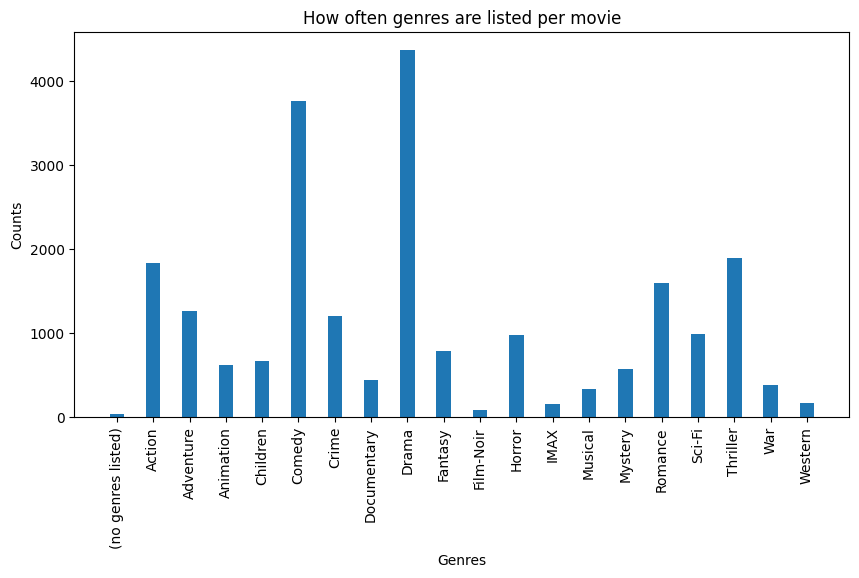

In [36]:
all_genres = []


def get_genres(row):
    for g in row['genres'].split('|'):
        all_genres.append(g)


movies_df.apply(get_genres, axis=1)
genres, genre_counts = np.unique(all_genres, return_counts=True)

fig = plt.figure(figsize=(10, 5))

# creating the bar plot
plt.bar(genres, genre_counts, width=0.4)

plt.xlabel('Genres')
plt.xticks(rotation=90)
plt.ylabel('Counts')
plt.title('How often genres are listed per movie')
plt.show()

# Question 10

## MF-based collaborative filter to predict the ratings of the original dataset

In [37]:
# Search MF w. bias space
dataset = df_to_dataset(ratings_df)
hyper_params = {
    'n_factors': np.arange(2, 52, 2, dtype=int),
    'verbose': [False]
}
search = GridSearchCV(SVD, hyper_params, cv=10, n_jobs=8, joblib_verbose=0)
search.fit(dataset)

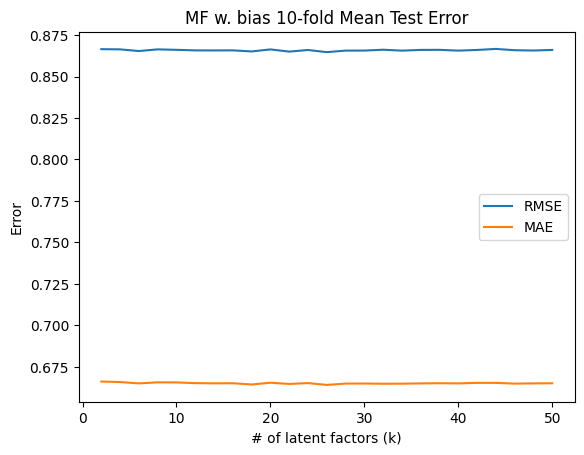

In [38]:
# Plotting
plot_rmse_mae(search, 'MF w. bias 10-fold Mean Test Error', '# of latent factors (k)',
              search.cv_results['param_n_factors'])

## Optimal number of latent factors

In [39]:
mean_rmse = search.cv_results['mean_test_rmse']
mean_mae = search.cv_results['mean_test_mae']
min_rmse_idx = np.argmin(mean_rmse)
min_mae_idx = np.argmin(mean_mae)

print(f'Min RMSE: {mean_rmse[min_rmse_idx]} at n_components={k_vals[min_rmse_idx]}')
print(f'Min MAE: {mean_mae[min_mae_idx]} at n_components={k_vals[min_mae_idx]}')
print(f'Number of movie genres: 19')

Min RMSE: 0.8647156639675526 at n_components=26
Min MAE: 0.6640744214930608 at n_components=26
Number of movie genres: 19


No, the number of optimal latent factors is not the same as the number of genres. If we look at the loss, it is basically flat, which suggests that the number of latent factors has no effect.

## Performance on trimmed dataset subsets

In [40]:
hyper_params = {
    'n_factors': np.arange(2, 52, 2, dtype=int),
    'verbose': [False]
}
k_vals, mean_rmses = search_varied_datasets(SVD, hyper_params, 'n_factors')

100%|██████████| 4/4 [00:49<00:00, 12.45s/it]


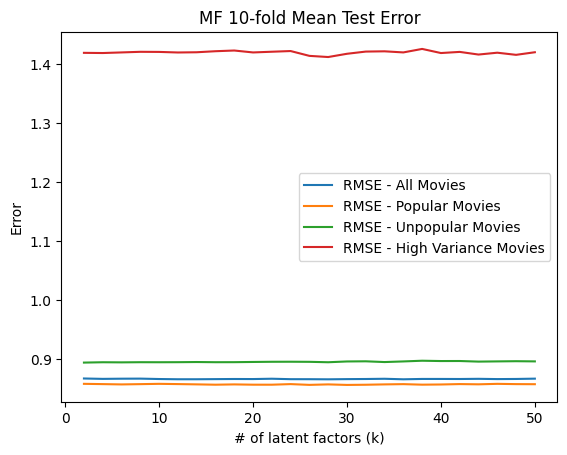

Min Mean RMSE for All Movies: 0.86587
Min Mean RMSE for Popular Movies: 0.85637
Min Mean RMSE for Unpopular Movies: 0.89420
Min Mean RMSE for High Variance Movies: 1.41182


In [41]:
# Plotting
plot_rmses(k_vals, mean_rmses, 'MF 10-fold Mean Test Error', '# of latent factors (k)')

In [42]:
# Predictions for ROC Curves
model = SVD(n_factors=26, verbose=False)
data_dfs = [ratings_df, pop_trimmed_df, unpop_trimmed_df, high_var_trimmed_df]
y_preds, y_true_binarised = get_roc_curve_data(model, data_dfs)

100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


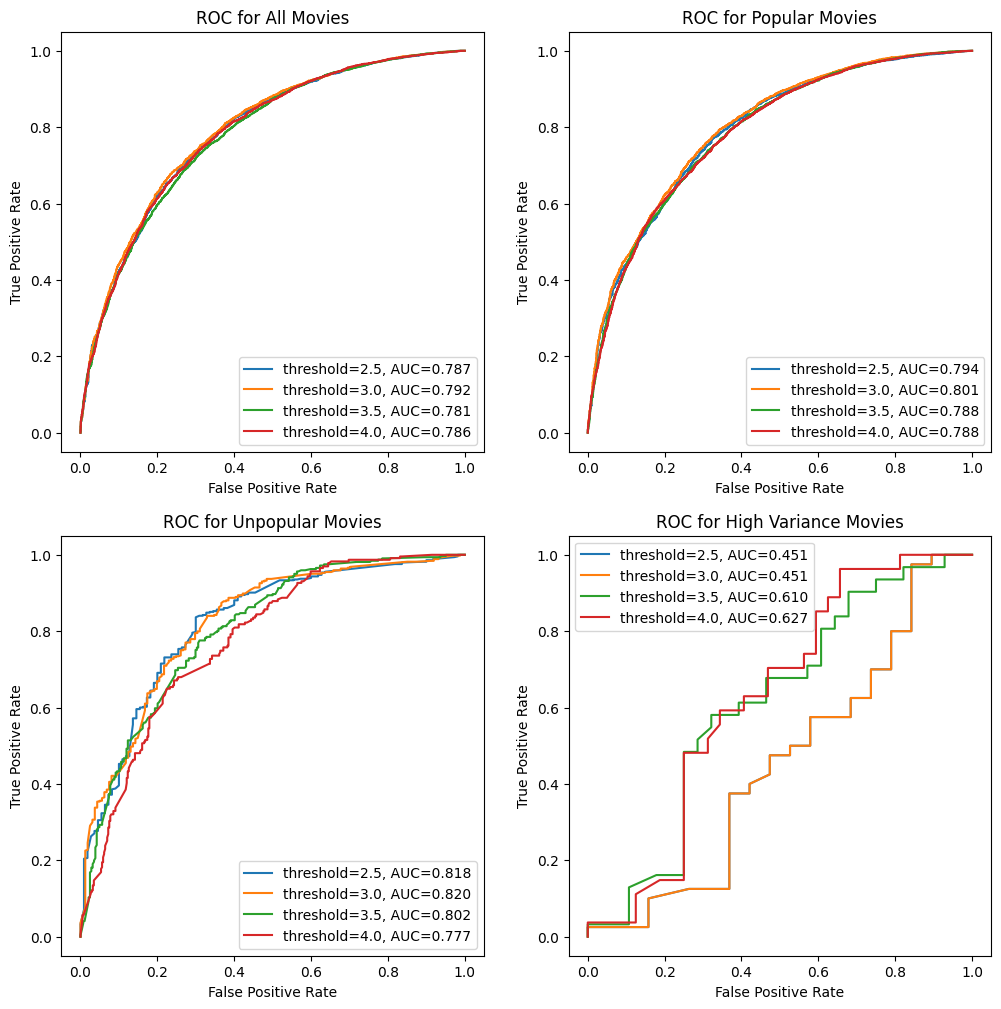

In [43]:
# ROC Curves
plot_roc_curves(y_preds, y_true_binarised)

# Question 11

## Naive collaborative filter to predict the ratings of the original dataset


In [44]:
default_mean = (max_rating - min_rating) / 2  # as the test set may contain users not in the train set


def naive_collaborative_filter(data_df: pd.DataFrame) -> List[float]:
    rmses = []
    for train_indices, test_indices in tqdm(KFold(n_splits=10).split(data_df), total=10):
        train_df = data_df.iloc[train_indices]
        test_df = data_df.iloc[test_indices]
        # Calculate means
        mean_ratings = train_df.groupby('userId_reindexed')['rating'].mean().to_dict()
        y_pred = []
        y_true = []

        def get_y_data(row):
            y_true.append(row['rating'])
            y_pred.append(mean_ratings.get(int(row['userId_reindexed']), default_mean))

        # Get predictions
        test_df.apply(get_y_data, axis=1)
        rmses.append(np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred)))

    return rmses

In [45]:
rmses = naive_collaborative_filter(ratings_df)
print(f'Average RMSE: {np.mean(rmses):.3f}')

100%|██████████| 10/10 [00:00<00:00, 13.95it/s]

Average RMSE: 0.941


## Performance on trimmed dataset subsets

In [46]:
# Search on varied datasets
all_rmses = []

for df in [ratings_df, pop_trimmed_df, unpop_trimmed_df, high_var_trimmed_df]:
    all_rmses.append(naive_collaborative_filter(df))

for rmses, name in zip(all_rmses, names):
    print(f'{name} - average RMSE: {np.mean(rmses):.3f}')

100%|██████████| 10/10 [00:00<00:00, 671.60it/s]

All Movies - average RMSE: 0.941
Popular Movies - average RMSE: 0.938
Unpopular Movies - average RMSE: 0.914
High Variance Movies - average RMSE: 1.449


# Question 12

In [47]:
# Get ROC data
data_dfs = [ratings_df]
knn_model = KNNWithMeans(k=20, sim_options={'name': 'pearson'}, verbose=False)
nmf_model = NMF(n_factors=16, verbose=False)
mf_bias_model = SVD(n_factors=26, verbose=False)
models = [knn_model, nmf_model, mf_bias_model]
model_names = ['KNN', 'NMF', 'MF w. bias']
all_y_preds = []
all_y_true_binarised = []

for m in models:
    y_preds, y_true_binarised = get_roc_curve_data(m, data_dfs)
    all_y_preds.append(y_preds)
    all_y_true_binarised.append(y_true_binarised)

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


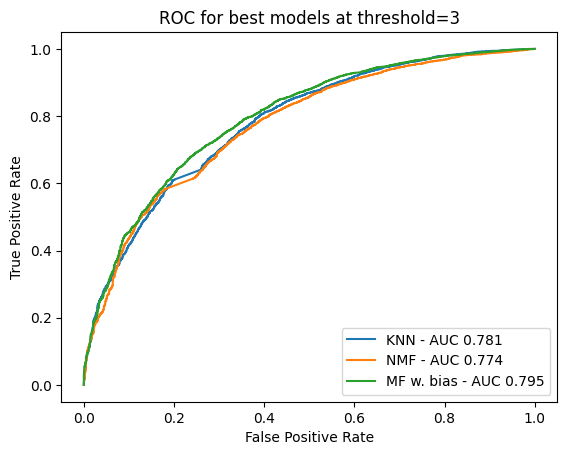

In [48]:
chosen_threshold = 3
index_of_3 = true_thresholds.index(chosen_threshold)
for y_pred, y_true, name in zip(all_y_preds, all_y_true_binarised, model_names):
    y_est = [y.est for y in y_pred[0]]
    labels = []
    y_t = y_true[0][index_of_3]
    fpr, tpr, _ = roc_curve(y_t, y_est)
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} - AUC {auc_val:.3f}')

plt.legend()
plt.title(f'ROC for best models at threshold={chosen_threshold}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

We can see here that the Matrix Factorisation with bias performs best at predicting ratings, which is reflected as well in the AUC score.

# Question 13
Precision measures whether a model can recommend the correct top $t$ items to a user. It does this by taking the fraction of items the user likes from the recommendations divided by the number of recommended items.

Recall measures how many items are correctly recommended to the user, but this time normalises by the number of items the user likes overall. This score will likely be very low if $|G| >> t$.

# Question 14

In [49]:
def calc_precision(recommended_items: set, ground_truth_items: set):
    return len(recommended_items.intersection(ground_truth_items)) / len(recommended_items)


def calc_recall(recommended_items: set, ground_truth_items: set):
    return len(recommended_items.intersection(ground_truth_items)) / len(ground_truth_items)


def get_liked_items(df: pd.DataFrame, threshold: int):
    above_threshold_df = df[df['rating'] >= threshold]
    user_liked_items = {}

    def process_row(row):
        user_id = int(row['userId_reindexed'])
        movie_id = int(row['movieId_reindexed'])
        if user_id not in user_liked_items:
            user_liked_items[user_id] = set()
        user_liked_items[user_id].add(movie_id)

    above_threshold_df.apply(process_row, axis=1)
    return user_liked_items

In [50]:
def get_user_recommendations(all_preds: List[Prediction], t: int, ground_truth_users:set) -> Dict[str, List[int]]:
    # Split up preds by user
    user_preds = {}
    for p in all_preds:
        if p.uid not in user_preds:
            user_preds[p.uid] = []
        user_preds[p.uid].append(p)

    # Sort and trim each pred by t, then extract items
    user_items = {}
    for user_id, preds in user_preds.items():
        # Only consider users with items >= t, which are also in the ground truth set
        if len(preds) >= t and user_id in ground_truth_users:
            top_t_preds = sorted(preds, key=lambda p: p.est)[-t:]
            user_items[user_id] = set([p.iid for p in top_t_preds])
    return user_items


def get_precision_recall(model, data_df: pd.DataFrame, t_vals: List[int]):
    avg_recalls = []
    avg_precisions = []
    for t in tqdm(t_vals):
        fold_recalls = []
        fold_precisions = []
        for train_indices, test_indices in KFold(n_splits=10).split(data_df):
            train_df = data_df.iloc[train_indices]
            train_dataset = df_to_dataset(train_df).build_full_trainset()
            test_df = data_df.iloc[test_indices]
            test_dataset = df_to_dataset(test_df)
            # this line looks weird because this library is weird.
            test_dataset = test_dataset.construct_testset(test_dataset.raw_ratings)

            test_user_ground_truth_items = get_liked_items(test_df, 3)

            model.fit(train_dataset)
            preds = model.test(test_dataset)
            test_user_recommended_items = get_user_recommendations(preds, t, set(test_user_ground_truth_items))

            recalls = [calc_recall(test_user_recommended_items[u],
                                   test_user_ground_truth_items[u]) for u in
                       test_user_recommended_items]
            precisions = [calc_precision(test_user_recommended_items[u],
                       test_user_ground_truth_items[u]) for u in
            test_user_recommended_items]

            fold_recalls.append(np.mean(recalls))
            fold_precisions.append(np.mean(precisions))

        avg_recalls.append(np.mean(fold_recalls))
        avg_precisions.append(np.mean(fold_precisions))

    return avg_precisions, avg_recalls

t_vals = list(range(1, 26))
knn_model = KNNWithMeans(k=20, sim_options={'name': 'pearson'}, verbose=False)
nmf_model = NMF(n_factors=16, verbose=False)
mf_bias_model = SVD(n_factors=26, verbose=False)
models = [knn_model, nmf_model, mf_bias_model]
model_names = ['KNN', 'NMF', 'MF w. bias']
all_precisions = []
all_recalls = []

for m in models:
    p, r = get_precision_recall(m, ratings_df, t_vals)
    all_precisions.append(p)
    all_recalls.append(r)

100%|██████████| 25/25 [03:01<00:00,  7.27s/it]


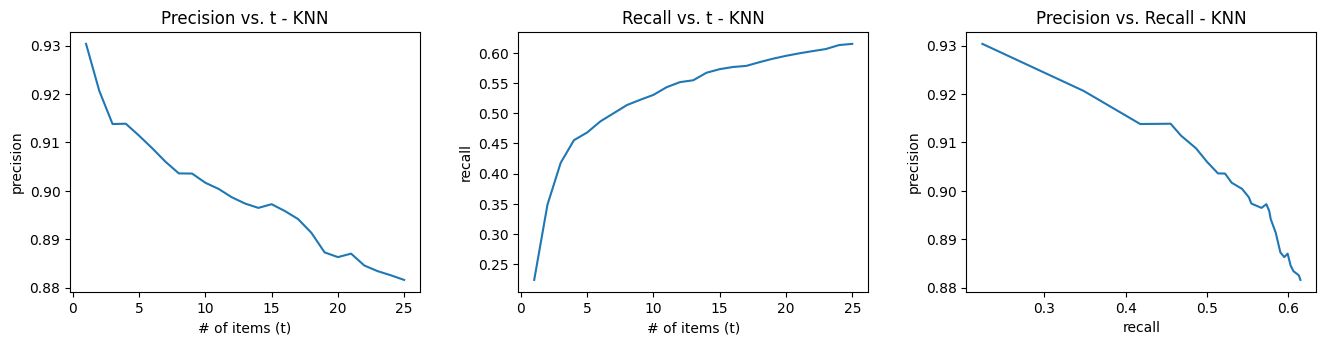

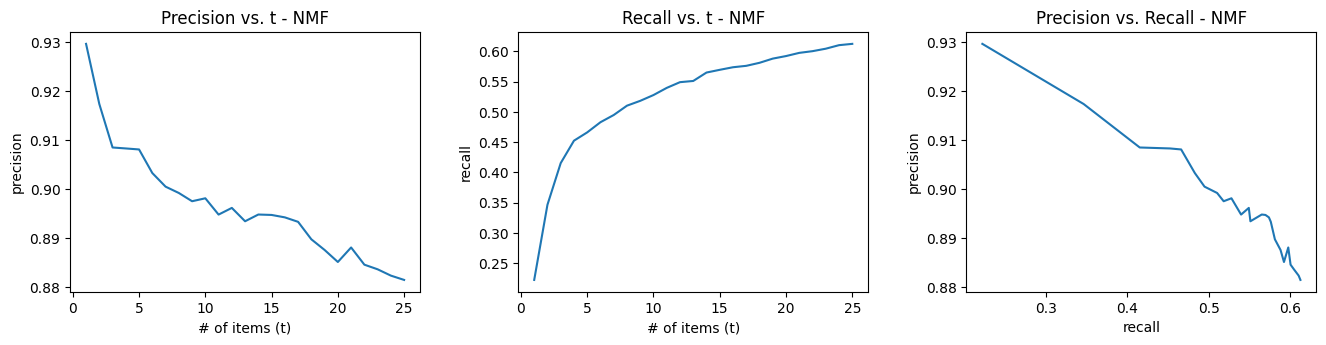

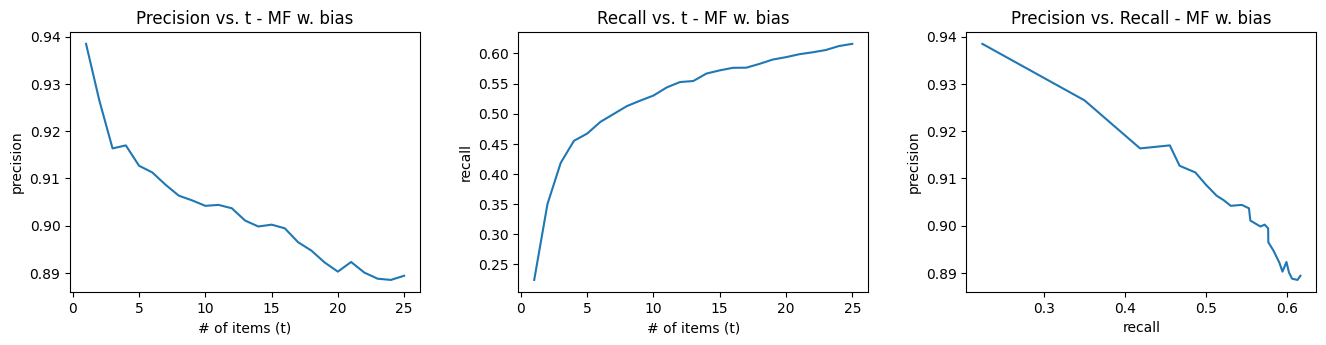

In [51]:
for name, precisions, recalls in zip(model_names, all_precisions, all_recalls):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

    fig.tight_layout(pad=4)

    ax1.plot(t_vals, precisions)
    ax1.set(xlabel='# of items (t)', ylabel='precision', title=f'Precision vs. t - {name}')

    ax2.plot(t_vals, recalls)
    ax2.set(xlabel='# of items (t)', ylabel='recall', title=f'Recall vs. t - {name}')

    ax3.plot(recalls, precisions)
    ax3.set(xlabel='recall', ylabel='precision', title=f'Precision vs. Recall - {name}')

    plt.show()

- Precision vs. $t$ plots: for all methods we can observe that precision generally decreases with the number of items, where the sharpest decline is from 1-4 items. This isn't too surprising as recommending the right items becomes more difficult, the more items there are to recommend.
- Recall vs. $t$ plots: for all methods, recall increases almost identically with the number of items. This is likely because $|S(t)| << |G|$ while $t$ is smaller (e.g comparing 5 top items to 30 available ground truths). As long as $|S(t)\cap G|$ increases with $t$ then the recall should improve. Unsurprisingly, as $t$ becomes very large the recommendations become less relevant so $|S(t)\cap G|$ begins to flatten out.
- Precision vs. Recall: the precision decreases almost linearly with recall. This makes sense if we consider their ratio: $\frac{|S(t)\cap G|}{|S(t)|} / \frac{|S(t)\cap G|}{|G|} = \frac{|G|}{|S(t)|}$ where only the denominator increases.

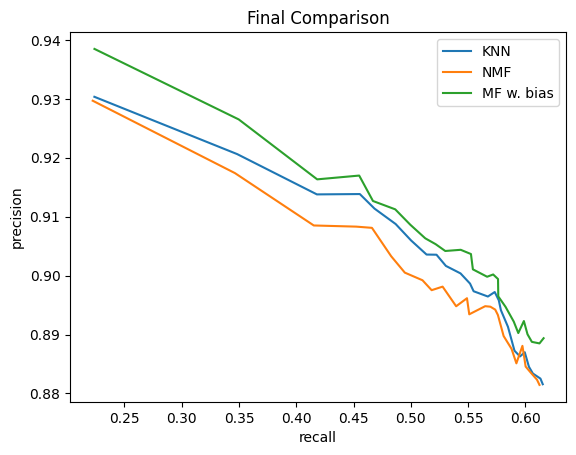

In [52]:
for name, precisions, recalls in zip(model_names, all_precisions, all_recalls):
    fig.tight_layout(pad=4)
    plt.plot(recalls, precisions, label=name)

plt.title('Final Comparison')
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend()
plt.show()

We can observe here that the MF with bias is the model that makes the most relevant recommendations as the trade-off in precision for recall is the lowest (i.e its curve sits above the others).